# **Installations:**

In [ ]:
pip install -q tensorflow==2.3.1

In [ ]:
pip install -q tensorflow_quantum==0.4.0

In [ ]:
pip install cirq==0.9.1

# **Imports:**

In [1]:
import tensorflow as tf

# Data Processing Tools
import numpy as np
from sklearn.model_selection import train_test_split 

# QML Tools
import tensorflow_quantum as tfq
import cirq
import sympy

# Visualization Tools
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt

#Fashion MNIST dataset
from tensorflow.keras.datasets import fashion_mnist as dataset

# **Preprocessing:**

In [28]:
#Load the datset
(X_train, y_train), (X_test, y_test) = dataset.load_data()

In [29]:
#Function to filter the dataset
def filter(x, y):

  #filter the data using labels
  label = (y == 5) | (y == 9)
  x, y = x[label], y[label]

  # convert labels to boolean
  y = y == 5

  return x,y

In [30]:
#Filter the train set
X_train, y_train = filter(X_train, y_train)

#Filter the test_set
X_test, y_test = filter(X_test, y_test)

In [31]:
#Normalizing the train and test image data
X_train = X_train/255.0
X_test = X_test/ 255.0

In [32]:
#Reshape images in the dataset
X_train = X_train.reshape(X_train.shape[0], *(28,28,1))
X_test = X_test.reshape(X_test.shape[0], *(28,28,1))

In [33]:
# Downscaling the images
X_train = tf.image.resize(X_train, (2,2)).numpy()
X_test = tf.image.resize(X_test, (2,2)).numpy()

In [34]:
#Splitting the training dataset into train and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.15, random_state=0)

# **Data Encoding:**
### **Step-1: Processing Pixel Values for Binary Encoding**

In [35]:
# Flattening the images
X_train = X_train.reshape(X_train.shape[0], *(1,4,1))
X_valid = X_valid.reshape(X_valid.shape[0], *(1,4,1))
X_test = X_test.reshape(X_test.shape[0], *(1,4,1))

In [36]:
# Binary Encoding of the dataset
def binary_encode(X,threshold=0.5):
  enc_images = list()
  for img in X:
    # pixel value is 1 if it's greater than threshold or else zero
    enc_image = [1 if j>threshold else 0 for j in img[0]]
    enc_images.append(enc_image)

  return np.array(enc_images)

In [37]:
X_train = binary_encode(X_train)

In [39]:
# Function to create quantum circuit from the image
def create_circuit_from_image(enc_image):
  qubits = cirq.GridQubit.rect(2,2)
  circuit = cirq.Circuit()
  for i, pixel in enumerate(enc_image):
    if pixel:
      circuit.append(cirq.X(qubits[i]))
  return circuit

In [40]:
X_train = [create_circuit_from_image(encoded_image) for encoded_image in X_train]

### **Step 2: Converting Cirq Circuits to tfq Tensors**

In [41]:
X_train_tfq = tfq.convert_to_tensor(X_train)

In [42]:
# Processing x_valid and x_test
X_valid = binary_encode(X_valid)
X_test = binary_encode(X_test)

In [43]:
X_valid = [create_circuit_from_image(encoded_image) for encoded_image in X_valid]
X_test = [create_circuit_from_image(encoded_image) for encoded_image in X_test]

In [44]:
X_valid_tfq = tfq.convert_to_tensor(X_valid)
X_test_tfq = tfq.convert_to_tensor(X_test)

# **Building the QNN:**

In [48]:
class QNN():
    def __init__(self, data_qubits, readout):
      self.data_qubits = data_qubits
      self.readout = readout

    #To add single qubit gate to the circuit
    def add_single_qubit_gate(self,circuit, gate, qubit_index):
      for index in qubit_index:
        circuit.append(gate(self.data_qubits[index]))

    #To add two qubit gate to the circuit
    def add_two_qubit_gate(self,circuit, gate, qubit_index):
      if len(qubit_index)!=2:
        raise Exception("The length of the list of indices passed for two qubit \
        gate operations must be equal to two")
      circuit.append(gate(self.data_qubits[qubit_index[0]], self.data_qubits[qubit_index[1]]))

    #To add new layer to teh circuit
    def add_layer(self, circuit, gate, symbol_gate):
      for i, qubit in enumerate(self.data_qubits):
        symbol = sympy.Symbol(symbol_gate+ '-' + str(i))
        circuit.append(gate(qubit, self.readout)**symbol)

In [46]:
# Function to create the QNN
def create_qnn():
    data_qubits = cirq.GridQubit.rect(2,2)  
    readout = cirq.GridQubit(-1, -1)         
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    qnn = QNN(
        data_qubits = data_qubits,
        readout=readout)

    # Add the ising coupling XX gate
    qnn.add_layer(circuit, cirq.XX, "xx")
    qnn.add_layer(circuit, cirq.ZZ, "zz")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [49]:
qmodel, model_readout = create_qnn()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


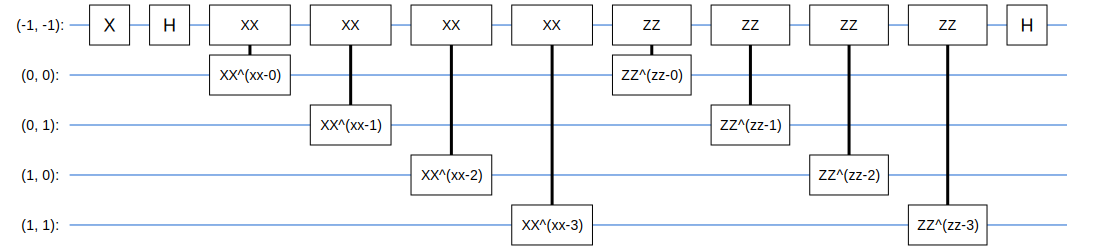

In [50]:
SVGCircuit(qmodel)

In [51]:
model = tf.keras.Sequential([                       
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),

    # Paramaterized Quantum Circuit for returning the expectation value
    tfq.layers.PQC(qmodel, model_readout),
])

In [52]:
# To use Hinge Loss, convert the labels to 1 and -1
y_train_h = np.array([1 if i==1 else -1 for i in y_train ])
y_valid_h = np.array([1 if i==1 else -1 for i in y_valid ])
y_test_h = np.array([1 if i==1 else -1 for i in y_test ])

In [53]:
# Define the custom Hinge Accuracy
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

# **QNN Training:**

In [54]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[hinge_accuracy])

In [ ]:
qnn_history = model.fit(
      X_train_tfq, y_train_h,
      batch_size=64,
      epochs=10,
      verbose=1,
      validation_data=(X_valid_tfq, y_valid_h))

In [ ]:
model.evaluate(X_test_tfq, y_test_h)

# **Visualisation of Results**

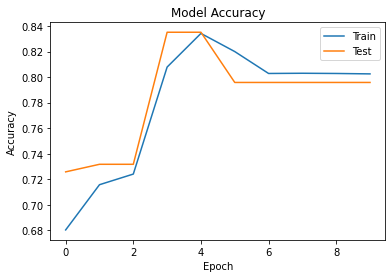

In [57]:
#Accuracy
plt.plot(qnn_history.history['hinge_accuracy'])
plt.plot(qnn_history.history['val_hinge_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'],loc="best")
plt.show()

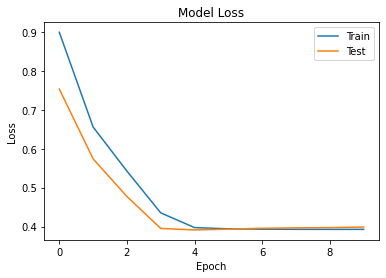

In [58]:
#Loss
plt.plot(qnn_history.history['loss'])
plt.plot(qnn_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'],loc="best")
plt.show()

# **References:**

* https://youtu.be/JtsmoS7vXYA
* https://github.com/Jayshah25/Classification-on-Fashion-MNIST-with-TensorFlow-TensorFlow-Quantum-and-Cirq
* https://www.tensorflow.org/quantum/tutorials/mnist
* https://quantumai.google/cirq/tutorials
* https://arxiv.org/pdf/1802.06002.pdf
* https://arxiv.org/pdf/1603.07678.pdf


